### Street View network analysis


In this notebook i will show how the library can be used to obtain images over a full network, and tag streets with the aggregated feature. I will focus on Green View Index (GVI) here and provide notebooks for additional features such as Sky View Factor or floor features later on. 

GVI is generally defined as the total pixels occupied by vegetation divided by the total pixels of the image. Let's suppose you have a binary mask $G_{ij}$ which has a value of 1 at points where vegetation is present. Then  

\begin{equation}
GVI = \frac{\sum_{i = 1}^{N}\sum_{j = 1}^{N}G{ij}}{N \times M}
\end{equation}

You can express that as a percentage, but it feels more natural to me to present it in the 0 - 1 range. It is the probability that a pixel is vegetation in the view. 

I don't think there's a particular consensus on what image perspective you need to use for calculating the metric. I use the lateral views, some studies use views in 4 cardinal directions, and others use the panoramic. Systems based on Mapillary use whatever image is available, sometimes it is a panoramic, sometimes it is a random view. 

GVI for some cities can be explored here:

https://senseable.mit.edu/treepedia/greenindex/buenos%20aires/-QCA4IEuoV32U51KXSsWYw


### Detecting features on a single image

Let's start by showing how to detect features on a single image.

In [1]:
from alivestreets.streetview_collection.streetview_collection import StreetViewImageCollector
import os
import cv2

#Obtain the view of a building (Capitol Records tower)
latitude = 34.10314604457623
longitude = -118.32669756849636
heading_angle = 90
pitch = 0
api_key = ""
output_dir = os.path.join(os.getcwd(),"data", "single_image_2")


image_collector = StreetViewImageCollector(api_key)

image,metadata = image_collector.collect_single_view(
    latitude,
    longitude,
    pitch,
    heading_angle,
    output_dir,
    filename = "single_view.jpg"
)



img = cv2.imread(os.path.join(output_dir, "single_view.jpg"))




ERROR ❌ Error reading from /Users/juanlegaria/Library/Application Support/Ultralytics/settings.json: "No Ultralytics setting 'openvino_msg'. \nView Ultralytics Settings with 'yolo settings' or at '/Users/juanlegaria/Library/Application Support/Ultralytics/settings.json'\nUpdate Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings."
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/juanlegaria/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Model downloaded.
The GVI is 0.18052001953125


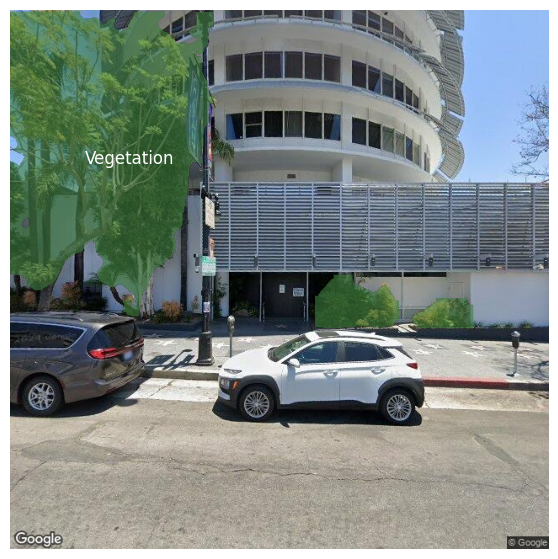

In [2]:
from alivestreets.features.gvi_feature import GVIFeatureExtractor
from alivestreets.visualization.mask_visualization import TransparentMaskVisualizer


gvi_extractor = GVIFeatureExtractor()
#Download the pretrained model
gvi_extractor.download_model(os.path.join(os.getcwd(), "model_facades.pt"))

results = gvi_extractor.compute(img)
vegetation_mask = results["mask"]

mask_visualizer = TransparentMaskVisualizer()
mask_visualizer.visualize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), [vegetation_mask], ["Vegetation"], colors = ["#3E7D3E"])
print(f"The GVI is {results['GVI']}")



### Collecting pictures over and network and tagging vegetation

In this second part of the notebook i will illustrate how to:

<ol>
<li>Collect Street View Images over a whole street network</li>
<li>Tag the Green View Index at the different streets</li>
<ol>

Skipping field name: unsupported OGR type: 5


Exported: data/network_2.geojson


<Axes: >

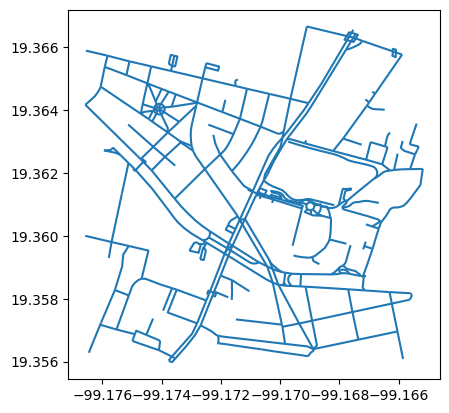

In [5]:
from alivestreets.network import network_retrieval, osm_features
from alivestreets.sampling.street_sampler import StreetSampler
import geopandas as gpd
import alivestreets as ast

lat = 19.36132786021484
lon = -99.17086000273748
radius = 600

graph = network_retrieval.get_graph_from_point(lat, lon, radius)
network_path = "data/network_2.geojson"
network_retrieval.export_graph_geojson(graph, network_path)

gdf = gpd.read_file(network_path)
gdf.plot()

The number of sampling points is 279


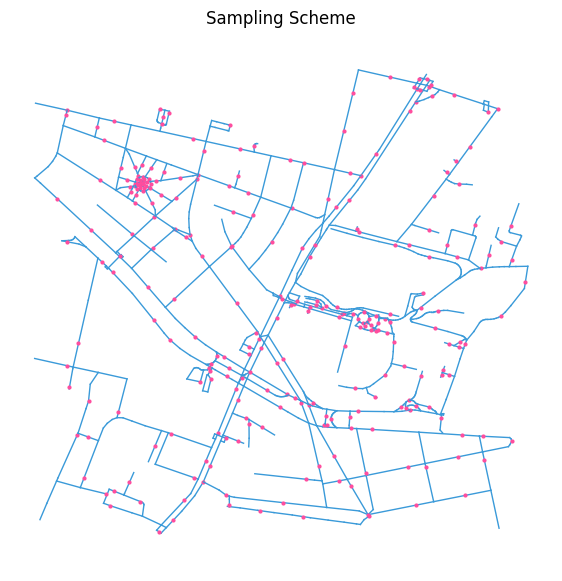

In [6]:
from alivestreets.sampling.street_sampler import StreetSampler

# Create a StreetSampler with a maximum number of sampling points
sampler = StreetSampler(max_points=200)

# Load the exported network
sampler.open_streets("data/network_2.geojson")

# Sample the streets
sampler.sample_streets_no_intersections()

# Optional: draw sampling scheme
sampler.draw_sampling_scheme(width=7, height=7, node_size = 2)

print(f"The number of sampling points is {len(sampler.get_all_sampling_points())}")

In [8]:
from alivestreets.streetview_collection.streetview_network_collection import StreetViewNetworkCollector

#In this case i will simply obtain the sidewalk views.
network_image_collector = StreetViewNetworkCollector(
    "sidewalks",
    api_key
)

output_path_images = os.path.join(os.getcwd(), "data", "network_images_demo")


point_dictionaries = network_image_collector.collect_street_sampler_images(
    sampler,
    output_path_images
)


100%|██████████| 279/279 [06:25<00:00,  1.38s/it]


In [7]:
import json
from tqdm import tqdm
import os
import cv2

output_path_images = os.path.join(os.getcwd(), "data", "network_images_demo")
#Once you have obtained the images one time you can load the point dictionary 
#which by default is stored in the output_path
path_points_dictionary = os.path.join(output_path_images, "point_dictionaries.jsonl")
data = []

#Open the point dictionaries
with open(path_points_dictionary, "r") as f:
    for line in f:
        data.append(json.loads(line))


#Compute the GVI for each point in the network
gvi_points = []
for i in tqdm(range(0,len(data))):
    point_dictionary = data[i]
    view_paths = point_dictionary["view_paths"]

    gvi = 0
    n_paths = len(view_paths)
    for j in range(0,len(view_paths)):
        img = cv2.imread(view_paths[j])
        results = gvi_extractor.compute(img)
        gvi += results["GVI"]/n_paths
    
    gvi_points.append(gvi)

  0%|          | 0/279 [00:00<?, ?it/s]

100%|██████████| 279/279 [05:33<00:00,  1.20s/it]


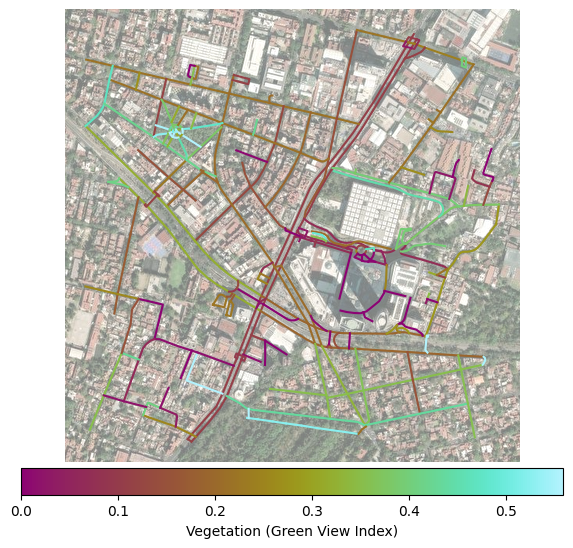

In [16]:
from alivestreets.visualization.map_visualizer import MapVisualizer
import cmcrameri.cm as cmc
#Great, now you tag the GVI just like every other feature.
sampler.tag_streets(
    "GVI", 
    gvi_points,
    method = "mean"
)

vis = MapVisualizer()
vis.initialize_map(figsize = (7,7))

vis.add_street_sampler(sampler, 
"GVI", 
variable_type="continuous",
edge_width = 1.5,
cmap = cmc.hawaii)

vis.draw_networks(
    colorbar_label = "Vegetation (Green View Index)", 
    colorbar_orientation = "horizontal",
    min_percentile = 5,
    max_percentile = 95)
#The default is cartodb light
#Since this is vegetation i will use a World Imagery basemap 
#to compare. 
vis.add_basemap(
    alpha = 0.5,
    tile_url = "https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}")
vis.finalize_map()



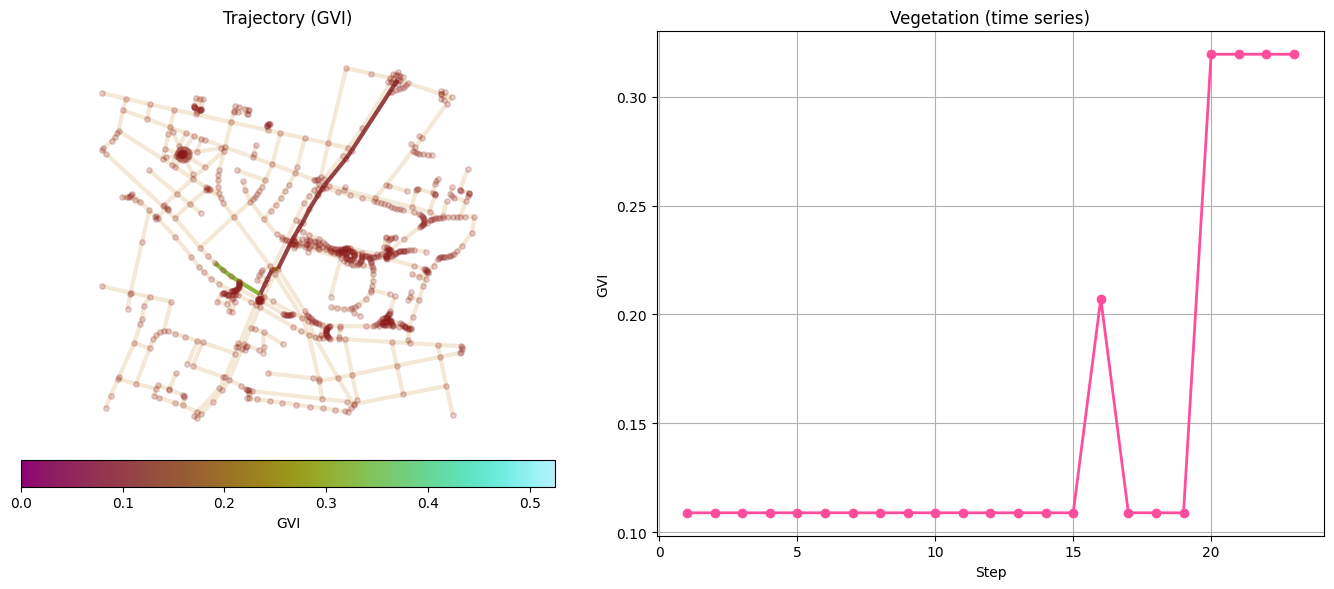

In [23]:
#Let's analyze how vegetation varies over a trajectory
#This similar to methods used in the mesoscopic_features.ipynb notebook
from alivestreets.network.graph_utilities import build_graph_from_sampler
from alivestreets.network.graph_utilities import attach_sampler_segment_attributes_to_graph
from alivestreets.visualization.trajectory_visualizer import plot_trajectory_on_graph, plot_attribute_time_series
import networkx as nx
import matplotlib.pyplot as plt

graph = build_graph_from_sampler(sampler)
attach_sampler_segment_attributes_to_graph(graph, 
sampler, 
"GVI", 
aggregation = "mean")

initial_node = 1
final_node = 200
undirected_graph = graph.to_undirected()

trajectory = nx.shortest_path(undirected_graph, source=initial_node, target=final_node, weight="length")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the trajectory on the graph
plot_trajectory_on_graph(
    G=undirected_graph,
    trajectory=trajectory,
    attribute_name="GVI",
    edge_size = 3.0,
    width = 3.0, 
    node_size = 15,
    ax=ax1, 
    alpha = 0.2, 
    node_color = "#8B1A1A",
    cmap = cmc.hawaii,
    min_percentile = 5,
    max_percentile = 95
)

# Plot the time series
plot_attribute_time_series(
    trajectory=trajectory,
    G=undirected_graph,
    attribute_name="GVI",
    ax=ax2, 
    title = "Vegetation (time series)"
)

plt.tight_layout()
plt.show()

In [24]:
#If you want you can save the tagged streets as a geojson
from alivestreets.sampling.geojson_sampler_exporter import StreetSamplerGeojsonExporter

exporter = StreetSamplerGeojsonExporter(sampler)
exporter.export(os.path.join(os.getcwd(), "data", "vegetation_tagged.geojson"), default_method = "mean")

<Axes: >

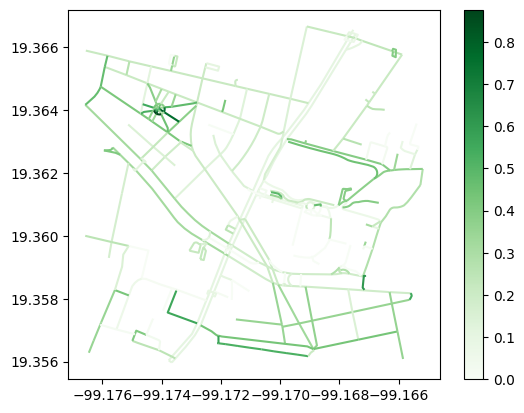

In [25]:
import geopandas as gpd

gdf = gpd.read_file(os.path.join(os.getcwd(), "data", "vegetation_tagged.geojson"))
gdf.plot(column="GVI", cmap="Greens", legend=True)